In [1]:
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import requests
import lxml
import webbrowser

import pandas as pd
import numpy as np
import re
import string

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

import gensim
from gensim.models import Word2Vec

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter


from textblob import TextBlob

import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luisz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\luisz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luisz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\luisz\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Recollecting the data we need

### How to fetch the HTML content from the webpage?

In [2]:
# Define the URL of the webpage
url = 'https://www.ign.com/reviews/movies'

# Define the headers to be sent with the request (simulating a user agent to get access)
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

# Make an HTTP GET request to the specified URL with the previous headers for then extract the HTML content from the response
html_text = requests.get(url, headers=headers).text

### How to use BeautifulSoup to parse HTML content so we can extract specific sections from a webpage?

In [3]:
# Create a BeautifulSoup object and specify the parser (lxml is very recommended)
soup = BeautifulSoup(html_text, 'lxml')

# Find the main element through its id
main = soup.find('main', {"id": 'main-content'})

# Find the review sections within the 'main' element
sections = main.section

In [4]:
# Find all <figcaption> elements which contain the score of each movie, in the HTML document
figcaption_elements = soup.findAll('figcaption')

# Iterate over each <figcaption> element and store it in an empty list
figcaption_values = []
for figcaption_element in figcaption_elements:
    figcaption_value = figcaption_element.text
    figcaption_values.append(figcaption_value)

In [5]:
figcaption_values

['5', '5', '6', '6', '7', '8', '7', '6', '7', '8', '7']

## How to obtain every review if each review is in its own URL?

In [6]:
# Find all <a> elements with the class 'item-body' in the HTML document so we have access to the URLs
review_links = soup.find_all('a', class_='item-body')

# Iterate over each preview of every review so we can access to the urls
hrefs = []
for review_link in review_links:
    href = review_link.get('href')
    hrefs.append(href)

In [7]:
hrefs

['/articles/wish-review-disney-animation',
 '/articles/please-dont-destroy-the-treasure-of-foggy-mountain-review-saturday-night-live',
 '/articles/trolls-band-together-review',
 '/articles/thanksgiving-review-eli-roth',
 '/articles/godzilla-minus-one-review',
 '/articles/david-holmes-the-boy-who-lived-review-harry-potter-documentary',
 '/articles/its-a-wonderful-knife-review',
 '/articles/the-hunger-games-the-ballad-of-songbirds-and-snakes-review',
 '/articles/the-marvels-review-brie-larson-samuel-l-jackson-mcu',
 '/articles/divinity-review-bella-thorne-eddie-alcazar']

In [8]:
base_url = 'https://www.ign.com'
data_from_urls = []

# Iterate over pairs of hrefs and figcaption_values(scores) using zip
for href, score in zip(hrefs, figcaption_values):
    
    # Construct the full URL by joining the base URL with the previous hrefs
    full_url = urljoin(base_url, href)
    
    response = requests.get(full_url, headers=headers)
    html_text = response.text
    soup = BeautifulSoup(html_text, 'lxml')
    page_title = soup.title.text
    paragraphs = soup.find_all('p', class_='jsx-3649800006')
    
    # Iterate over each <p> element and append data to the list
    for paragraph in paragraphs:
        
        # Append a dictionary containing title, score, and paragraph to the list
        data_from_urls.append({'Title': page_title, 'Score': score, 'Paragraph': paragraph.text})

### What if we wanted a Dataframe?

In [9]:
df = pd.DataFrame(data_from_urls)

In [10]:
df.head()

,Title,Score,Paragraph
0,Wish Review - IGN,5,Thinking back on the gems of the Disney Renais...
1,Wish Review - IGN,5,Standing on that legacy of emotional heft and ...
2,Wish Review - IGN,5,The impetus to bridge the past and present is ...
3,Wish Review - IGN,5,"In the kingdom of Rosas, vaguely inspired by c..."
4,Wish Review - IGN,5,But during her job interview to become the kin...


### Do we have empty paragraphs?

In [11]:
df[df['Paragraph']=='']

,Title,Score,Paragraph


#### What if we had?

In [12]:
df.replace(' ', np.nan, inplace=True)

In [13]:
df.dropna(subset=['Paragraph'], inplace=True)

## How can we clean our data in order to make predicions?

### Converting it to lowercase, removing numbers and non-alphanumeric characters, and tokenizing it using NLTK

In [14]:
def preprocess_text(text):
    
    # Convert the text to lowercase
    text = text.lower()
    
    # Remove numbers from the text
    text = re.sub(r'\d+', '', text)
    
    # Remove non-alphanumeric characters from the text
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize the text using NLTK
    tokens = nltk.word_tokenize(text)
    
    return tokens

### Remove English stop words from a list of tokens using NLTK

In [15]:
def remove_stopWords(tokens):
    
    # Get the set(list) of English stop words from NLTK
    stopWords = set(stopwords.words('english'))
    
    # Filter out stop words from the list of tokens
    filtered_tokens = [words for words in tokens if words not in stopWords]
    
    return filtered_tokens

### Perform lemmatization on a list of tokens using the WordNet lemmatizer

In [16]:
def lemmatization(tokens):
    
    # Create a WordNet lemmatizer object
    lemmatizer = nltk.WordNetLemmatizer()
    
    # Lemmatize each token in the list
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens

### Remove proper nouns

In [17]:
def remove_proper_names(tokens):
    
    # Perform part-of-speech tagging on the list of tokens
    tagged_tokens = pos_tag(tokens)
    
    # Filter out tokens that are identified as proper nouns
    filtered_tokens = [token[0] for token in tagged_tokens if token[1] != 'NNP']
    return filtered_tokens

## Integrate all the previous functions

In [18]:
def clean_text(text):
    tokens = preprocess_text(text)
    filtered_tokens = remove_stopWords(tokens)
    lemmatization_tokens = lemmatization(filtered_tokens)
    non_proper_name_tokens = remove_proper_names(filtered_tokens)
    clean_text = ' '.join(non_proper_name_tokens)
    return clean_text

In [19]:
df['cleaned_Paragraph'] = df['Paragraph'].apply(clean_text)

In [20]:
df.head()

,Title,Score,Paragraph,cleaned_Paragraph
0,Wish Review - IGN,5,Thinking back on the gems of the Disney Renais...,thinking back gems disney renaissance stands s...
1,Wish Review - IGN,5,Standing on that legacy of emotional heft and ...,standing legacy emotional heft equally moving ...
2,Wish Review - IGN,5,The impetus to bridge the past and present is ...,impetus bridge past present also embedded aest...
3,Wish Review - IGN,5,"In the kingdom of Rosas, vaguely inspired by c...",kingdom rosas vaguely inspired cultures iberia...
4,Wish Review - IGN,5,But during her job interview to become the kin...,job interview become kings assistant asha disc...


In [21]:
del df['Paragraph']

### Can we remove specific words, single-character words, and words with only consonants?

In [22]:
words_to_remove = ['just', 'thats']

In [23]:
def remove_words(text):
    
    # Iterate over words_to_remove and replace each occurrence with an empty string
    for word in words_to_remove:
        text = text.replace(word, '')
    return text

df['cleaned_Paragraph'] = df['cleaned_Paragraph'].apply(remove_words)

def remove_single_character_words(text):
    
    # Split the text into words and filter out words with length <= 1
    return ' '.join(word for word in text.split() if len(word) > 1)

df['cleaned_Paragraph'] = df['cleaned_Paragraph'].apply(remove_single_character_words)

In [24]:
def delete_consonant_words(paragraph):
    
    # Define a regular expression pattern to match words with only consonants
    consonant_pattern = re.compile('^[^aeiou]+$')
    
    # Split the paragraph into words
    words = paragraph.split()
    
    # Filter out words that match the consonant pattern
    filtered_words = [word for word in words if not consonant_pattern.match(word)]
    
    # Join the filtered words back into a paragraph
    return ' '.join(filtered_words)

for paragraph in df['cleaned_Paragraph']:
    filtered_paragraph = delete_consonant_words(paragraph)

In [25]:
df.head()

,Title,Score,cleaned_Paragraph
0,Wish Review - IGN,5,thinking back gems disney renaissance stands s...
1,Wish Review - IGN,5,standing legacy emotional heft equally moving ...
2,Wish Review - IGN,5,impetus bridge past present also embedded aest...
3,Wish Review - IGN,5,kingdom rosas vaguely inspired cultures iberia...
4,Wish Review - IGN,5,job interview become kings assistant asha disc...


# Analyzing the Data

### Worst Reviews & Best Reviews

In [26]:
print(f'Worst reviews: \n{df.groupby("Title")["Score"].max().sort_values().head(3)}')
print()
print(f'Best reviews: \n{df.groupby("Title")["Score"].max().sort_values(ascending=False).head(3)}')


Worst reviews: 
Title
Please Don’t Destroy: The Treasure of Foggy Mountain Review - IGN    5
Wish Review - IGN                                                    5
Thanksgiving Review - IGN                                            6
Name: Score, dtype: object

Best reviews: 
Title
David Holmes: The Boy Who Lived Review - IGN    8
Divinity Review - IGN                           8
Godzilla Minus One Review - IGN                 7
Name: Score, dtype: object


## Word Cloud

### How can I generate a word cloud to visualize the frequency of words ?

In [27]:
# Combine the cleaned paragraphs into a single text string
text = " ".join(i for i in df.cleaned_Paragraph)
stopwords = set(STOPWORDS)

# Generate Word Cloud
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

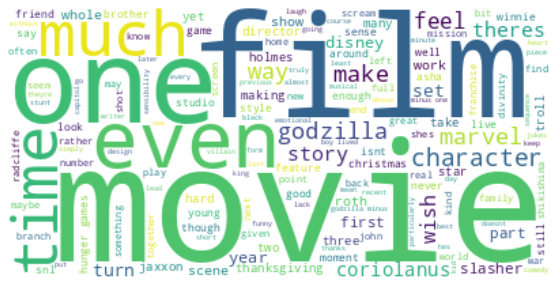

In [28]:
# Set the figure size
plt.figure( figsize=(15,5))

# Display the WordCloud
plt.imshow(wordcloud, interpolation='bilinear')

# Turn off axis
plt.axis("off")
plt.show()

## How can I know if the reviews are positive or negatives?

## Sentiment Analysis with TextBlob

In [29]:
for paragraph in df['cleaned_Paragraph']:
    
    # Preprocess the paragraph using TextBlob
    preprocessed_paragraph = TextBlob(paragraph).lower().strip()

    # Get the sentiment analysis results
    sentiment = preprocessed_paragraph.sentiment

    # Extract polarity. -1 negative, 1 positive, 0 neutral sentiment
    polarity = sentiment.polarity

    # Determine sentiment label based on polarity
    if polarity > 0:
        sentiment_label = "Positive"
    elif polarity < 0:
        sentiment_label = "Negative"
    else:
        sentiment_label = "Neutral"

    # Print the paragraph and corresponding sentiment label
    print(f"Paragraph: {paragraph}\nSentiment: {sentiment_label}")

Paragraph: thinking back gems disney renaissance stands seemed trust young audiences dramatically complex material granted moments could considered adult think frollos hellfire hunchback notre dame since many films adapted great literary classics ancient folktales substantial stakes resonated even mature viewers
Sentiment: Positive
Paragraph: standing legacy emotional heft equally moving music latest feature walt disney animation meant commemorate studios centennial wish falls short attaining electrifying heights maybe much pressure put single original concept purpose honor disney history fair judge came
Sentiment: Positive
Paragraph: impetus bridge past present also embedded aesthetics wish directed disney veteran chris buck tarzan fawn veerasunthorn former animator directing first time animation style reads graphic studios dcg features doesnt precisely match animated exuberance seen spiderverse movies teenage mutant ninja turtles mutant mayhem similarly attempts call mind handdrawn e

In [30]:
#Create an emprty list to append sentiment labels
sentiment_labels = []

for paragraph in df['cleaned_Paragraph']:
    preprocessed_paragraph = TextBlob(paragraph).lower().strip()
    sentiment = preprocessed_paragraph.sentiment
    polarity = sentiment.polarity

    if polarity > 0:
        sentiment_label = "Positive"
    elif polarity < 0:
        sentiment_label = "Negative"
    else:
        sentiment_label = "Neutral"
    # Append the result to our empty list
    sentiment_labels.append(sentiment_label)

### Can we visualize the results?

In [31]:
# Define colors for different sentiment labels
sentiment_colors = {
    "Positive": "green",
    "Negative": "red",
    "Neutral": "yellow"
}

# Count the occurrences of each label (sentiment)
label_counts = Counter(sentiment_labels)

# Unzip the counter into separate lists for labels and corresponding counts
labels, heights = zip(*label_counts.items())

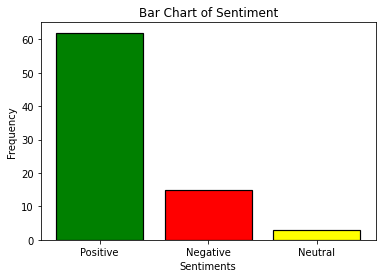

In [32]:
# Set the bars for the bar chart
bars = plt.bar(labels, height=heights, edgecolor='black', linewidth=1.2)

# Iterate over a list of bars and assigned colors to each bar 
for bar, color in zip(bars, [sentiment_colors[label] for label in labels]):
    bar.set_facecolor(color)

# Set labels and title for the plot
plt.xlabel("Sentiments")
plt.ylabel("Frequency")
plt.title("Bar Chart of Sentiment")

# Show the plot
plt.show()

# How can I predict scores?

# Testing Models

### How can I prepare text data for machine learning?

In [33]:
X = df['cleaned_Paragraph']
y = df['Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


## Which models can I use?

### Support Vector Regression

In [34]:
sv_model = SVR(kernel='linear')  # There are many different kernels like 'linear', 'rbf', etc.

# Train the model
sv_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_sv = sv_model.predict(X_test_tfidf)

#IGN Scores are Integers
y_pred_sv = np.around(y_pred_sv,0)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_sv)
r_squared = r2_score(y_test, y_pred_sv)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')

Mean Squared Error: 0.4166666666666667
R-squared: 0.5714285714285714


In [35]:
print(y_pred_sv)
print(np.array(y_test))

[6. 6. 6. 6. 6. 6. 6. 7. 6. 6. 7. 7. 6. 7. 7. 7. 7. 6. 6. 7. 6. 7. 6. 7.]
['6' '5' '6' '6' '6' '6' '5' '7' '5' '5' '7' '7' '7' '7' '7' '8' '8' '6'
 '6' '7' '5' '7' '5' '8']


### Random Forest

In [36]:
rf_model = RandomForestRegressor(n_estimators=150, random_state=42, max_depth=10)

# Train the model
rf_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_tfidf)

#IGN Scores are Integers
y_pred_sv = np.around(y_pred_rf,0)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r_squared_rf = r2_score(y_test, y_pred_rf)

print(f'Mean Squared Error (Random Forest): {mse_rf}')
print(f'R-squared (Random Forest): {r_squared_rf}')

Mean Squared Error (Random Forest): 0.4735194882830697
R-squared (Random Forest): 0.5129513834802711


In [37]:
print(np.around(y_pred_rf,0))
print(np.array(y_test))

[6. 6. 6. 6. 7. 7. 6. 7. 7. 6. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 5. 7. 6. 7.]
['6' '5' '6' '6' '6' '6' '5' '7' '5' '5' '7' '7' '7' '7' '7' '8' '8' '6'
 '6' '7' '5' '7' '5' '8']


## How can I perform hyperparameter tuning, find the best parameters, and evaluate the model?

## Grid Searches

### SVR

In [38]:
# Define the parameter grid for SVR
svr_param_grid = {'C': [0.1, 1, 10],
                  'kernel': ['linear', 'rbf', 'poly'],
                  'gamma': ['scale', 'auto']}

# Create the SVR model
svr_model = SVR()

# Create GridSearchCV for SVR
svr_grid_search = GridSearchCV(svr_model, svr_param_grid, cv=5, scoring='neg_mean_squared_error')
svr_grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and model
best_svr_params = svr_grid_search.best_params_
best_svr_model = svr_grid_search.best_estimator_

# Predict on the test set
y_pred_svr = best_svr_model.predict(X_test_tfidf)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
r_squared_svr = r2_score(y_test, y_pred_svr)

print("Best parameters for SVM:", best_svr_params)
print(f'Mean Squared Error (SVM): {mse_svr}')
print(f'R-squared (SVM): {r_squared_svr}')


Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Mean Squared Error (SVM): 0.43752060665383513
R-squared (SVM): 0.5499788045846267


### Random Forest

In [ ]:
# Define the parameter grid for Random Forest
rf_param_grid = {'n_estimators': [50, 100, 150],
                 'max_depth': [None, 10, 20, 30],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4]}

# Create the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Create GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and model
best_rf_params = rf_grid_search.best_params_
best_rf_model = rf_grid_search.best_estimator_

# Predict on the test set
y_pred_rf_gs = best_rf_model.predict(X_test_tfidf)

# Evaluate the model
mse_rf_gs = mean_squared_error(y_test, y_pred_rf_gs)
r_squared_rf_gs = r2_score(y_test, y_pred_rf_gs)

print("Best parameters for Random Forest:", best_rf_params)
print(f'Mean Squared Error (Random Forest): {mse_rf_gs}')
print(f'R-squared (Random Forest): {r_squared_rf_gs}')


## Is there a a way to automate the process for predicting?

## Pipelines

### Naive Bayes

In [ ]:
nb = Pipeline([('vect', CountVectorizer()), # Convert text data into a bag-of-words representation
               ('tfidf', TfidfTransformer()), # Transform the bag-of-words representation into TF-IDF features
               ('clf', MultinomialNB()), # Multinomial Naive Bayes classifier
              ])

# Train the pipeline on the training data
nb.fit(X_train, y_train)

In [ ]:
df['Score'].unique()

In [ ]:
y_pred_nb = nb.predict(X_test)

# Print the accuracy of the model
print('accuracy %s' % accuracy_score(y_pred_nb, y_test))

# Print a classification report including precision, recall, and F1-score
print(classification_report(y_test, y_pred_nb,target_names= df['Score'].unique()))

This results are not good at all. The recalls are not accetable nor the precision and nor the accuracy.

In [ ]:
print(np.around(y_pred_rf,0))
print(np.array(y_test))

### Linear Support Vector Machine

In [ ]:
svm = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
svm.fit(X_train, y_train)

In [ ]:
y_pred_svm = svm.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred_svm, y_test))
print(classification_report(y_test, y_pred_svm,target_names=df['Score'].unique()))

And we have a winner! SVM is the best model for predicting in this case. 95$ of accuracy, great precision and recall. 

In [ ]:
print(y_pred_svm)
print(np.array(y_test))